# CS437 Deep Learning PA1 (part 2)

This part of PA1 is meant to help you familiarize yourself with making very basic models in PyTorch. This part will involve 
1. creating models
2. understanding the difference between Regression and Classification tasks
3. (most importantly) learning how to write code to train and evaluate your model

A few notes:
* Please ask one of the TA's beforehand if you wish to use any extra module or library (you won't need to)
* Please try to write clean code (the only thing more sad than academic dishonesty is messy code)
* Please attempt this assignment honestly, the course staff hold their Office Hours everyday and we want to help you succeed in this class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs, make_regression, make_moons
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn

## 1. A Toy Regression Example

Usually when we attempt a new type of problem, regardless of its complexity, it's best to start with a very simple example. We usually use "toy" datasets for this purpose.

In this example, we'll be creating our own dataset for Regression. Recall that a Regression task involves taking data to predict some kind of continous variable: usually this is just *one number* like the price of a House or the price of Bitcoin the next day, but this task can be extended to predicting *multiple numbers* like the coordinates of Bounding Boxes on your favorite Object Detection model.

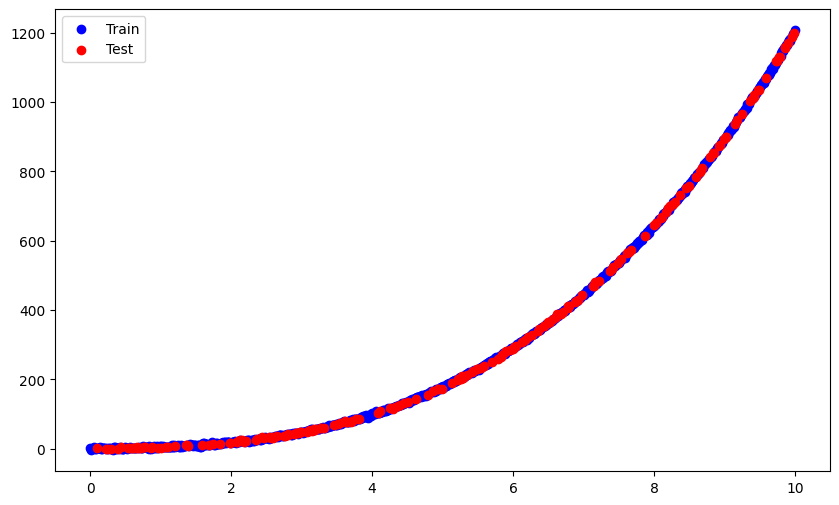

In [2]:
# Make a regression dataset, and cast to DataFrames
X = torch.arange(start=0, end=10, step=0.01).unsqueeze(1)
y = X**3 + 2*X**2 + 0.5*X + 1 + torch.randn(size=X.shape) * 2

# Cast these to tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a plot
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Train', color='blue')
plt.scatter(X_test, y_test, label='Test', color='red')
plt.legend()
plt.show()

Always remember to familiarize yourself with how the data is structured. What's the shape? What are the datatypes I'm working with? Are there any unit-dimensional axes I should keep in mind for later?

In [3]:
# What do these look like?
print(f"The shape of X_train is: {X_train.shape}") # keeping the training instances
print(f"The shape of y_train is: {y_train.shape}")
print()
print(f"The first 5 instances of X_train are:\n{X_train[:5]}")
print()
print(f"The first 5 instances of y_train are:\n{y_train[:5]}")

The shape of X_train is: torch.Size([800, 1])
The shape of y_train is: torch.Size([800, 1])

The first 5 instances of X_train are:
tensor([[0.2900],
        [5.3500],
        [6.9500],
        [5.5700],
        [8.3600]])

The first 5 instances of y_train are:
tensor([[ -1.4345],
        [211.7928],
        [436.8279],
        [237.6034],
        [728.5639]])


Now we move to the exciting part: creating your first Regression Model in PyTorch.

It is recommended you read through the relevant official documentation properly for whatever tasks you run into. PyTorch is a **framework** so you need to play by it's rules, though it is very flexible and forgiving if you want to experiment in doing things your way.

Instantiate a Neural Network using PyTorch that outputs a single number. Note that you *should* include non-linearities like ReLU since your dataset in non-linear too.

In [4]:
# TODO Task 1: Create a class for your model

## code here
# making a neural net using pytorch nn module
# hidden shapes will be a list containing the number of hidden layers
# the input layer will be sent as a parameter but the output shape is being fixed at 1
class NeuralNet(nn.Module):
    def __init__(self, in_shape, hidden_shapes):
        super(NeuralNet, self).__init__()
        self.hidden_layers_list = []
        self.hidden_layers_list.append(nn.Linear(in_shape, hidden_shapes[0]))
        for i in range(1, len(hidden_shapes)):
            self.hidden_layers_list.append(nn.Linear(hidden_shapes[i-1], hidden_shapes[i]))
        self.output_layer = nn.Linear(hidden_shapes[-1], 1)
        # now we have instantiated all the layers with their corresponding neurons shapes
        print(self.hidden_layers_list)
        
    def forward(self, input_matrix):
        z = input_matrix
        # z = z.reshape(-1, 1)
        for i in range(len(self.hidden_layers_list)):
            z = self.hidden_layers_list[i](z)
            z = nn.functional.relu(z)
        return self.output_layer(z)
        
        
            
## end here

In [5]:
print(X_train.shape[1])


1


[Linear(in_features=1, out_features=50, bias=True), Linear(in_features=50, out_features=30, bias=True)]
The shape of your model's output is torch.Size([200, 1]), and dtype is torch.float32
The shape of the labels is torch.Size([800, 1]), and dtype is torch.float32


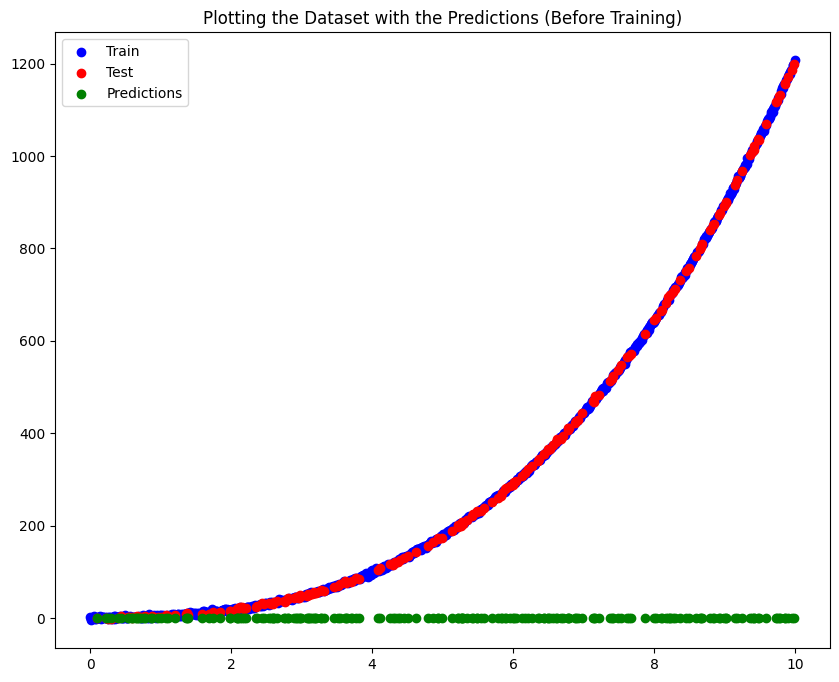

In [6]:
# TODO Task 2: Instantiate your model
## code here
model = NeuralNet(X_train.shape[1], [50, 30])

## end here

## Check if your model's output is the right shape (is it what you'd expect?) # yes it is because i input a 200 sample tensor and got a 200 sample output
model.eval()
with torch.no_grad():
    y_pred = model(X_test) # Make predictions on the Test Dataset to check the output

print(f"The shape of your model's output is {y_pred.shape}, and dtype is {y_pred.dtype}")
print(f"The shape of the labels is {y_train.shape}, and dtype is {y_train.dtype}")

# Plot the predictions
plt.figure(figsize=(10, 8))
plt.scatter(X_train, y_train, label='Train', color='blue')
plt.scatter(X_test, y_test, label='Test', color='red')
plt.scatter(X_test, y_pred, label='Predictions', color='green')
plt.title("Plotting the Dataset with the Predictions (Before Training)")
plt.legend()
plt.show()

It will save you a **lot** of debugging if you do a dummy pass of your model on the data before moving on to training. This way you're likely to run into inevitable shape errors and debug them earlier, saving a lot of time and headache.

Now for the most important part of this assignment: **training your Neural Network**.

As you can (hopefully) see in the plot above, the Predictions made by the model are very far from what they should be. After training the model, we will come back to this plot and (again hopefully) see that the Predictions are much closer to their true values.

Notes for this part:
* The PyTorch documentation is your best friend
* Think about what Loss Function should be used for Regression
* Print out the values of the Loss every now and then so you can monitor if the loss is decreasing or not
* A GPU is not necessary for this part, you can run 5000 epochs in around 5 seconds using the CPU

In [7]:
# TODO Task 3: Create the Loss Function and Optimizer (make sure to specify the correct model parameters). Also define the number of Epochs.
## code here
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.01) # lets start with 0.005 
epochs = 5000 * 10
## end here

In [8]:
# using the lr 0.005 and 100000 the loss is 669
# increasing lr to 0.01 and decreasing 5000 epochs the loss is 9346.4
# increasing lr to 0.05 and the loss is 4755
# increasing epochs to 10000 and the loss is 1288
# lets increase the learning rate to 0.1 and the loss is 1668
# increasing epochs to 20000
# loss is 704 at 50000 and 0.0075
# finally i am tired of this and this is the best i can do at 0.05 lr and 50000 epochs with a loss of 816

In [9]:
# TODO Task 4: Train the model

## code here
for i in range(0,epochs, 1):
    optimizer.zero_grad()
    predictions = None
    predictions = model(X_train)
    loss = loss_function(predictions, y_train)
    loss.backward()
    optimizer.step()
    if (i % 1000 == 0):
        print(f"the loss at epoch {i} is {loss.item()}")
## end here

the loss at epoch 0 is 217325.0
the loss at epoch 1000 is 9896.2373046875
the loss at epoch 2000 is 7568.71923828125
the loss at epoch 3000 is 6167.8525390625
the loss at epoch 4000 is 5229.125
the loss at epoch 5000 is 4546.29541015625
the loss at epoch 6000 is 4022.216552734375
the loss at epoch 7000 is 3606.93115234375
the loss at epoch 8000 is 3271.7724609375
the loss at epoch 9000 is 2998.350830078125
the loss at epoch 10000 is 2773.739990234375
the loss at epoch 11000 is 2588.261474609375
the loss at epoch 12000 is 2434.39697265625
the loss at epoch 13000 is 2306.169677734375
the loss at epoch 14000 is 2198.783447265625
the loss at epoch 15000 is 2108.360107421875
the loss at epoch 16000 is 2031.7596435546875
the loss at epoch 17000 is 1966.4334716796875
the loss at epoch 18000 is 1910.3082275390625
the loss at epoch 19000 is 1861.7015380859375
the loss at epoch 20000 is 1819.244384765625
the loss at epoch 21000 is 1781.8248291015625
the loss at epoch 22000 is 1748.53662109375
th

You should be seeing that the Loss of the model decreased as training progressed.

Now we can use the model to find the new predictions on the Test Set, and visualize them to see that they are better than before.

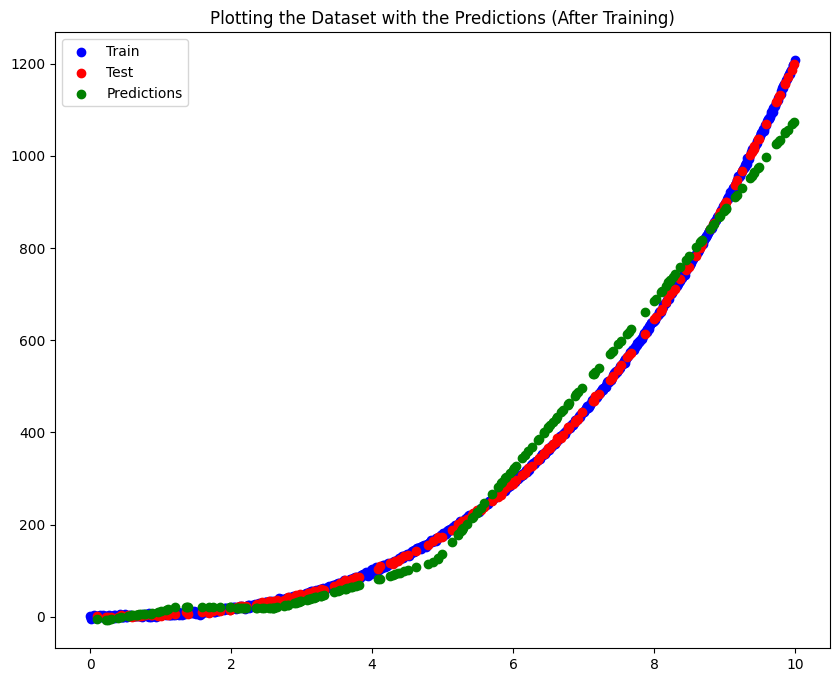

In [10]:
# Make predictions on the test dataset
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
# Plot the predictions
plt.figure(figsize=(10, 8))
plt.scatter(X_train, y_train, label='Train', color='blue')
plt.scatter(X_test, y_test, label='Test', color='red')
plt.scatter(X_test, y_pred, label='Predictions', color='green')
plt.title("Plotting the Dataset with the Predictions (After Training)")
plt.legend()
plt.show()

In [11]:
# remove later
from sklearn.metrics import r2_score
print(r2_score(y_test, y_pred) *100)

98.88749481164353


## 2. A Toy Classification Example

Recall that Classification is taking data to predict a certain *class* for each instance. This is different from Regression in the sense the predictions are not Continous, but Discrete Variables.

In this section, we will explore the Moons Dataset, which involves predicting between two classes based on the coordinates of an instance.

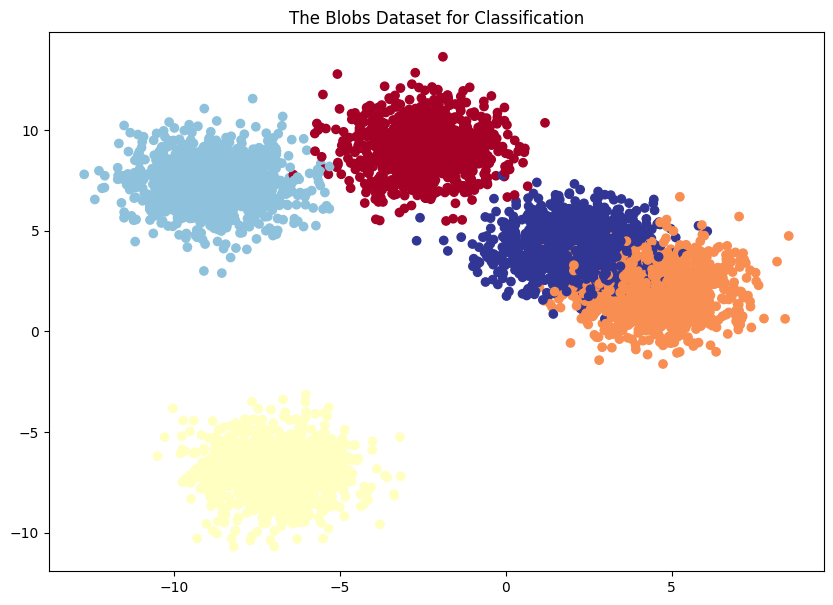

In [97]:
# Make a Classification dataset (DO NOT CHANGE THIS CODE)
X, y = make_blobs(
    n_samples=5000,
    n_features=2,
    centers=5,
    cluster_std=1.2,
    random_state=42
)

# Cast these to Tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Plot the dataset
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)
plt.title("The Blobs Dataset for Classification")
plt.show()

In [98]:
# What do these look like?
print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of y_train is: {y_train.shape}")
print()
print(f"The first 5 instances of X_train are:\n{X_train[:5]}")
print()
print(f"The first 5 instances of y_train are:\n{y_train[:5]}")

The shape of X_train is: torch.Size([4000, 2])
The shape of y_train is: torch.Size([4000])

The first 5 instances of X_train are:
tensor([[5.0629, 1.2887],
        [4.1720, 2.1628],
        [5.5917, 1.8267],
        [5.1539, 2.0658],
        [6.3194, 0.3626]])

The first 5 instances of y_train are:
tensor([1, 1, 1, 1, 1])


In [99]:
print(len(set(y_train.tolist())))

5


**Please read:** 

There aren't any drastic changes from the last section. You will create your model, your loss function, optimizer and the training loop in the same fashion.

**Hints:**
* You should frame this problem as a Multi-class Classification problem, so use the Cross Entropy Loss Function (look up how to use it in PyTorch)
* You might run into a *shape* error when computing the loss inside the training loop, so consider using `squeeze` or `unsqueeze`
* You might run into a *dtype* error when computing the loss inside the training loop (though not likely). Notice how the labels are represented as integers, and you will find your model outputs floating point numbers. Look into how the Cross Entropy Loss Function within PyTorch works, what it expects, what it outputs etc.

In [100]:
# TODO Task 5: Create a class for your model
## code here
class ClassificationNN(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_shapes):
        super(ClassificationNN, self).__init__()
        self.hidden_layers_list = []
        self.hidden_layers_list.append(nn.Linear(in_shape, hidden_shapes[0]))
        for i in range(1, len(hidden_shapes)):
            self.hidden_layers_list.append(nn.Linear(hidden_shapes[i-1], hidden_shapes[i]))
        self.output_layer = nn.Linear(hidden_shapes[-1], out_shape)
        # now we have instantiated all the layers with their corresponding neurons shapes
        print(self.hidden_layers_list)
        print(self.output_layer)
        
    def forward(self, input_matrix):
        z = input_matrix
        # z = z.reshape(-1, 1)
        for i in range(len(self.hidden_layers_list)):
            z = self.hidden_layers_list[i](z)
            z = nn.functional.relu(z)

        return self.output_layer(z)
## end here

In [101]:
# TODO Task 6: Instantiate your model
## code here
model = ClassificationNN(X_train.shape[1], len(set(y_train.tolist())), [100,40,15])
## end here

# Check if your model's output is the right shape (is it what you'd expect?)
model.eval()
with torch.no_grad():
    tmp = model(X_train)
print(f"The shape of your model's output is {tmp.shape}, and dtype is {tmp.dtype}")
print(f"The shape of the labels is {y_train.shape}, and dtype is {y_train.dtype}")

[Linear(in_features=2, out_features=100, bias=True), Linear(in_features=100, out_features=40, bias=True), Linear(in_features=40, out_features=15, bias=True)]
Linear(in_features=15, out_features=5, bias=True)
The shape of your model's output is torch.Size([4000, 5]), and dtype is torch.float32
The shape of the labels is torch.Size([4000]), and dtype is torch.int64


Keeping in mind the hints given above, write another Training loop for your model (could involve subtle changes as compared to before).

We recommend that you attempt to functionalize your code, i.e. write a function that will perform your train loop. We will provide the prototype:
```python
def train(
    model: nn.Module,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int = 10
):
    pass
```

In [102]:
# TODO Task 7: Create a loss function and optimizer
## code here
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr= 0.11) # lets start with 0.01 and 5000 epochs
epochs = 10000
## end here

In [103]:
# TODO Task 8: Train your model
## code here

for i in range(0,epochs, 1):
    optimizer.zero_grad()
    predictions = None
    predictions = model(X_train)
    target_labels_one_hot = torch.nn.functional.one_hot(y_train, 5).float()
    loss = loss_function(predictions, target_labels_one_hot)
    loss.backward()
    optimizer.step()
    if (i % 1000 == 0):
        print(f"the loss at epoch {i} is {loss.item()}")
## end here

the loss at epoch 0 is 1.743446946144104
the loss at epoch 1000 is 0.21979975700378418
the loss at epoch 2000 is 0.1616661548614502
the loss at epoch 3000 is 0.1398766040802002
the loss at epoch 4000 is 0.12828992307186127
the loss at epoch 5000 is 0.12103071063756943
the loss at epoch 6000 is 0.11602316051721573
the loss at epoch 7000 is 0.11234267055988312
the loss at epoch 8000 is 0.10951326042413712
the loss at epoch 9000 is 0.10726401954889297


Hopefully you found that the loss was decreasing (if you printed it out during each epoch). Note that this is not very helpful in gauging how well the model performed. Something like the Accuracy is more interpretable. In the following cell, when you evaluate your model, print out the Loss **and the Accuracy** of your model on the Test Data.

You should aim to get an accuracy over 85%, though you can get something closer to 95%.

In [104]:
# TODO Task 9: Evaluate your model
## code here
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = torch.argmax(y_pred, dim = 1)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred) *100)
## end here

96.2
